# Evaluation Reinforcement Learning 

Membres du groupe : 
- Antoine Rodriguez (FA)
- Bastien Beffa (FI)
- Douaa Benhaddouche (FA)
- Lilia Harireche (FA)


## Exercice 1

In [ ]:
import numpy as np
import base  # module pour initialiser l'environnement

Initialisons un environnement `Maze` : 

In [ ]:
env = base.Maze()

### 1

La politique décrite par les probabilités d'actions {W: 0.1, S:0.4, E:0.4, N:0.1} est représentée de la façon suivante :

In [ ]:
# 1.1  create policy p 
p = np.ones((env.get_nb_states(),
             env.get_nb_actions()))*np.array([0.1, 0.4, 0.4, 0.1])

Nous aurons besoin des fonctions suivantes pour la prochaine question.

In [ ]:
# Iterative Policy Evaluation  from td1-ex4
def ipe(policy, env, gamma, epsilon=0.001):
    v = np.zeros((env.get_nb_states()))
    q = np.sum(env.p()*(env.r() + gamma * v[np.newaxis, np.newaxis, :]), axis=2)
    nv = np.sum(policy * q, axis=1)
    delta = np.sum(np.abs(nv-v))

    while delta > epsilon:
        v = nv
        q = np.sum(env.p()*(env.r() + gamma * v[np.newaxis, np.newaxis, :]), axis=2)
        nv = np.sum(policy * q, axis=1)
        delta = np.sum(np.abs(nv-v))
    
    return nv

def mc_prediction(policy, env, gamma, nb_episodes):
    nba = env.get_nb_actions()
    nbs = env.get_nb_states()
    
    for ne in range(nb_episodes):
        # Générer un épisode
        episode = []
        state = env.reset()
        final = False
        while not final:
            action = np.random.choice(nba, p=policy[state])
            ns, renf, final, _ = env.step(action)
            episode.append([state, action, ns, renf])
            state = ns
        
        # Mettre à jour les valeurs
        retour = 0
        compteur = np.zeros((nbs)) # compteur d'états
        somme = np.zeros((nbs)) # somme des valeurs d'états
        for s, a, ns, r in reversed(episode):
            retour = r + gamma * retour
            compteur[s] += 1
            somme[s] += retour
        
    v = somme.copy() 
    for s in range(nbs):
        if compteur[s]>0:
            v[s] /= compteur[s]
    return v

def td_0(policy, env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    nbs = env.get_nb_states()

    v = np.zeros((nbs)) # valeurs d'états
    
    for ne in range(nb_episodes):
        state = env.reset()
        final = False
        while not final:
            action = np.random.choice(nba, p=policy[state])
            ns, renf, final, _ = env.step(action)
            v[state] += alpha * (renf + gamma * v[ns] - v[state])
            state = ns
        
    return v

### 2 

Tout d'abord initialisons le facteur d'ammortissement `gamma` $\gamma$ et les valeurs produites par l'agorithme **IPE**

In [ ]:
gamma = 0.9  

values_IPE = ipe(p, env, gamma, 0.001)

Nous comparerons chacunes de ses valeurs  avec les algorithme de **Monte-Carlo** predictif et **TD(0)**



In [ ]:
nb_episodes = 100

values_mc = []
values_td_0 = []
for iter in range(nb_episodes):
    values_mc.append(mc_prediction(p, env, gamma, iter+1))
    values_td_0.append(td_0(p, env, gamma, 0.1, iter+1))

On peut alors calculer les différentes erreurs de prédictions par rapport aux valeurs 
produites par les deux algorithmes.

In [ ]:
error_mc = [np.sqrt(np.sum((values - values_IPE)**2)) 
            for values in values_mc]
error_td_0 = [np.sqrt(np.sum((values - values_IPE)**2)) 
               for values in values_td_0]

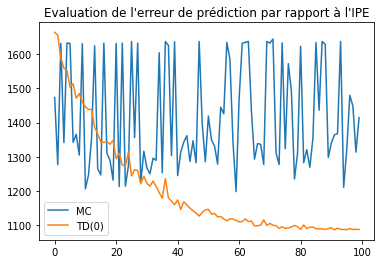

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(nb_episodes), error_mc, label='MC')
plt.plot(range(nb_episodes), error_td_0, label='TD(0)')
plt.legend()
plt.title('Evaluation de l\'erreur de prédiction par rapport à l\'IPE')
plt.show()

On observe une forte diminution de l'erreur pour l'algorithme TD(0) : il se rapproche des valeurs approchées par **IPE**.

Pour ce qui est de MC l'evolution de l'erreur est chaotique sans que nous ayons pu en identifier la cause.

###3

On implémente les algorithmes **Td(0) n-step** et **TD($\lambda$)** :

In [ ]:
def td_0_step(policy, env, gamma, alpha, nb_episodes, n_step):
    nba = env.get_nb_actions()
    nbs = env.get_nb_states()

    v = np.zeros((nbs)) # initializing states values
    
    for ne in range(nb_episodes):
        state = env.reset()
        final = False
        while not final:
            g_t = 0  # n_step return
            for i in range (0, n_step):  # applying n_step 
                action = np.random.choice(nba, p=policy[state])
                ns, renf, final, _ = env.step(action)
                g_t += (gamma**i) * renf  +  (gamma**(i+1)) * v[ns]  # n_step return update : recurrent formula

            v[state] += alpha * (g_t - v[state])  
            action = np.random.choice(nba, p=policy[state]) 
            new_state, renf, final, _ = env.step(action)
            state = new_state  # changing state
    return v

def td_lambda(policy, env, gamma, alpha, nb_episodes, lbd):
    nba = env.get_nb_actions()
    nbs = env.get_nb_states()

    v = np.zeros((nbs)) # valeurs d'états
    e = np.zeros((nbs))  # trace d'éligibilité
    
    for ne in range(nb_episodes):
        state = env.reset()
        final = False

        while not final:
            action = np.random.choice(nba, p=policy[state])
            ns, renf, final, _ = env.step(action)
            # formule de récurrence pour màj les traces
            vec_state = np.zeros((nbs))
            vec_state[state] = 1 
            e = gamma * lbd * e + vec_state

            d = renf + gamma * v[ns] - v[state]  # màj delta_t
            v += alpha * d * e
            state = ns  # nouvel état
        
    return v

Executons alors ces algorithmes et comparons les résultats obtenus avec les deux méthodes précédentes.

In [ ]:
# td_0 steps execution  (with n=2, 5 and 10)
nb_episodes = 20
values_td_0_step_2 = []
values_td_0_step_5 = []
values_td_0_step_10 = []
for iter in range(nb_episodes):
    values_td_0_step_2.append(td_0_step(p, env, gamma, 0.1, iter+1,2))
    values_td_0_step_5.append(td_0_step(p, env, gamma, 0.1, iter+1,5))
    values_td_0_step_10.append(td_0_step(p, env, gamma, 0.1, iter+1,10))

In [ ]:
# computing errors
error_td_0_step_2 = [np.sqrt(np.sum((values - values_IPE)**2)) 
               for values in values_td_0_step_2]
error_td_0_step_5 = [np.sqrt(np.sum((values - values_IPE)**2)) 
               for values in values_td_0_step_5]
error_td_0_step_10 = [np.sqrt(np.sum((values - values_IPE)**2)) 
               for values in values_td_0_step_10]

In [ ]:
# td_lambda execution
nb_episodes = 20
values_td_lambda = []
for iter in range(nb_episodes):
    values_td_lambda.append(td_lambda(p, env, gamma, 0.1, iter+1,0.5))

# error
error_td_lambda = [np.sqrt(np.sum((values - values_IPE)**2)) 
               for values in values_td_lambda]

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [9, 7]

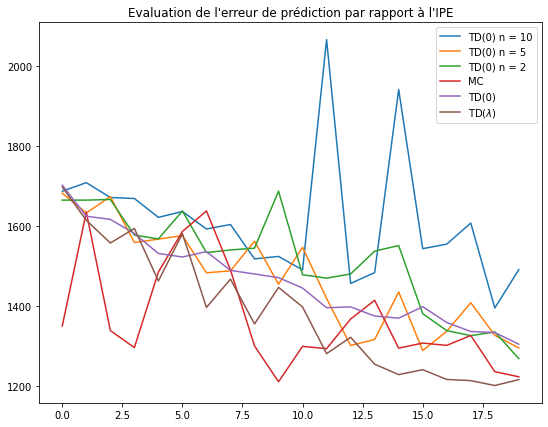

In [ ]:
plt.plot(range(nb_episodes), error_td_0_step_10, label ='TD(0) n = 10')
plt.plot(range(nb_episodes), error_td_0_step_5, label ='TD(0) n = 5')
plt.plot(range(nb_episodes), error_td_0_step_2,label ='TD(0) n = 2')
plt.plot(range(nb_episodes), error_mc[0:20], label='MC')
plt.plot(range(nb_episodes), error_td_0[0:20], label='TD(0)')
plt.plot(range(nb_episodes), error_td_lambda, label='TD($\lambda$)')
plt.legend()
plt.title('Evaluation de l\'erreur de prédiction par rapport à l\'IPE')
plt.show()

A 20 épisodes **TD($\lambda$)** semble présenter des résultats plus proches de l'IPE.

## Exercice 2

Chargons un nouvel environnement :

In [ ]:
env = base.Maze()

gamma = 0.9 

In [ ]:
def egreedy_policy(qvalues, epsilon):
    nb_actions = qvalues.shape[1]
    policy = np.ones((env.get_nb_states(), env.get_nb_actions())) * epsilon / nb_actions
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] += 1 - epsilon
    return policy

def egreedy_decision(qvalues, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(qvalues[state]))
    else:
        return np.argmax(qvalues[state])

Nous définissons dans le code suivant trois algorithmes modifiés pour évaluer le contrôle , l'objectif étant d'afficher les différents résultats suivant des choix de $\varepsilon_0$ et $T$.

In [ ]:
def monte_carlo_m(env, gamma, nb_episodes, epsilon_0, T): 
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    n = np.zeros((env.get_nb_states(), nba))
    policy = np.ones((env.get_nb_states(), nba)) / nba
    
    nba_by_episodes = [] # counting number of actions by episode
    r_by_episodes = [] # counting total rewards by episode
    for ne in range(nb_episodes):
        # changing epsilon in function of T (decreasing it for large T)
        if ne <= T:  
            epsilon = epsilon_0
        else :
            epsilon = epsilon_0 / np.sqrt(ne - T)

        state = env.reset()
        episode = []
        r_by_episode = 0 # setting reward for the actual state

        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            r_by_episode += r # update total reward 
            episode.append([state, action, nvstate, r])
            state = nvstate

        nba_by_episodes.append(len(episode)) 
        r_by_episodes.append(r_by_episode)

        g = 0 # return
        for s, a, ns, r in reversed(episode):
            g = r + gamma * g
            n[s, a] += 1
            q[s, a] += (g - q[s,a]) / n[s,a] 
        
        policy = egreedy_policy(q, epsilon)  # applying egreedy with the new epsilon
        
    return q, nba_by_episodes, r_by_episodes  # return needed values


## the two other functions are modified versions of sarsa and q_learning with the 
## same modifications as above. 

def sarsa_m(env, gamma, alpha, nb_episodes, epsilon_0, T):
    q = np.zeros((env.get_nb_states(), env.get_nb_actions()))

    nba_by_episodes = []
    r_by_episodes = []
    for ne in range(nb_episodes):
        if ne <= T: 
            epsilon = epsilon_0
        else :
            epsilon = epsilon_0 / np.sqrt(ne - T)

        state = env.reset()
        action = egreedy_decision(q, state, epsilon)
        nba_by_episode = 1  # initialize counter of actions in current episode
        r_by_episode = 0
        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)
            nvaction = egreedy_decision(q, nvstate, epsilon)
            nba_by_episode += 1
            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]
            r_by_episode += target

            q[state, action] += alpha * (target - q[state, action])
            
            state = nvstate
            action = nvaction

        nba_by_episodes.append(nba_by_episode)
        r_by_episodes.append(r_by_episode)

    return q, nba_by_episodes, r_by_episodes

def q_learning_m(env, gamma, alpha, nb_episodes, epsilon_0, T):
    q = np.zeros((env.get_nb_states(), env.get_nb_actions()))

    nba_by_episodes = []
    r_by_episodes = []
    for ne in range(nb_episodes):
        if ne <= T: 
            epsilon = epsilon_0
        else :
            epsilon = epsilon_0 / np.sqrt(ne - T)

        state = env.reset()
        nba_by_episode = 0
        r_by_episode = 0
        while not env.is_final(state):
            action = egreedy_decision(q, state, epsilon)
            nba_by_episode += 1 
            nvstate, r, final, _ = env.step(action)
            
            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])
            r_by_episode += target
            
            q[state, action] += alpha * (target - q[state, action])
            
            state = nvstate

        nba_by_episodes.append(nba_by_episode)
        r_by_episodes.append(r_by_episode)

    return q, nba_by_episodes, r_by_episodes

### 1 

Utilisons les 3 fonctions précédentes pour comparer les algorithmes de renforcement **sarsa**, **MC-control** et **q-learning** : 

Premièrement regardons la différence des résultats pour plusieurs valeurs de $\varepsilon_0$ :

In [ ]:
gamma = 0.9
alpha = 0.1
nb_episodes = 20

monte_carlo_results = [[],[]]
sarsa_results = [[],[]]
q_learning_results = [[],[]]
for epsilon_0 in [0.08, 0.085, 0.09]:
    T = 10
    _, nba_by_episodes, r_by_episodes = monte_carlo_m(env, gamma, nb_episodes, epsilon_0, T)
    monte_carlo_results[0].append(nba_by_episodes)
    monte_carlo_results[1].append(r_by_episodes)

    _, nba_by_episodes, r_by_episodes = sarsa_m(env, gamma, alpha, nb_episodes, epsilon_0, T)
    sarsa_results[0].append(nba_by_episodes)
    sarsa_results[1].append(r_by_episodes)
    
    _, nba_by_episodes, r_by_episodes = q_learning_m(env, gamma, alpha, nb_episodes, epsilon_0, T)
    q_learning_results[0].append(nba_by_episodes)
    q_learning_results[1].append(r_by_episodes)

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 7]

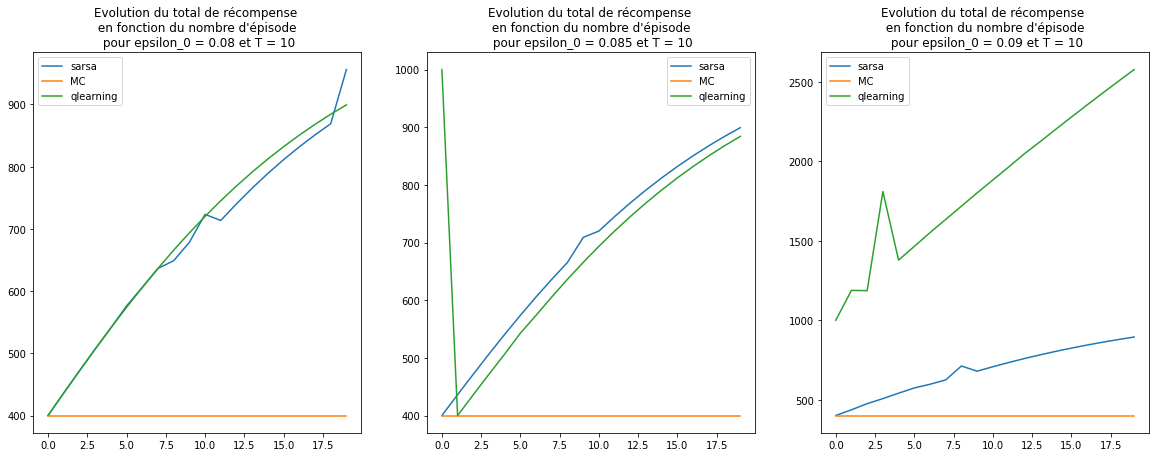

In [ ]:
epsilon_0 = [0.08, 0.085, 0.09]
fig, axes = plt.subplots(1,3)
for i in [0,1,2]:
    fig = plt.subplot(1,3,i+1)
    fig = plt.plot(sarsa_results[1][i], label='sarsa')
    fig = plt.plot(monte_carlo_results[1][i], label='MC')
    fig = plt.plot(q_learning_results[1][i], label='qlearning')
    fig = plt.legend()
    fig = plt.title('Evolution du total de récompense \n en fonction du nombre d\'épisode \n pour epsilon_0 = {} et T = 10'.format(epsilon_0[i]))
fig = plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig = plt.show()

L'algorithme **Q-Learning** semble devancer **SARSA** en augmentant la valeur de $\varepsilon_0$ en terme de récompense total.


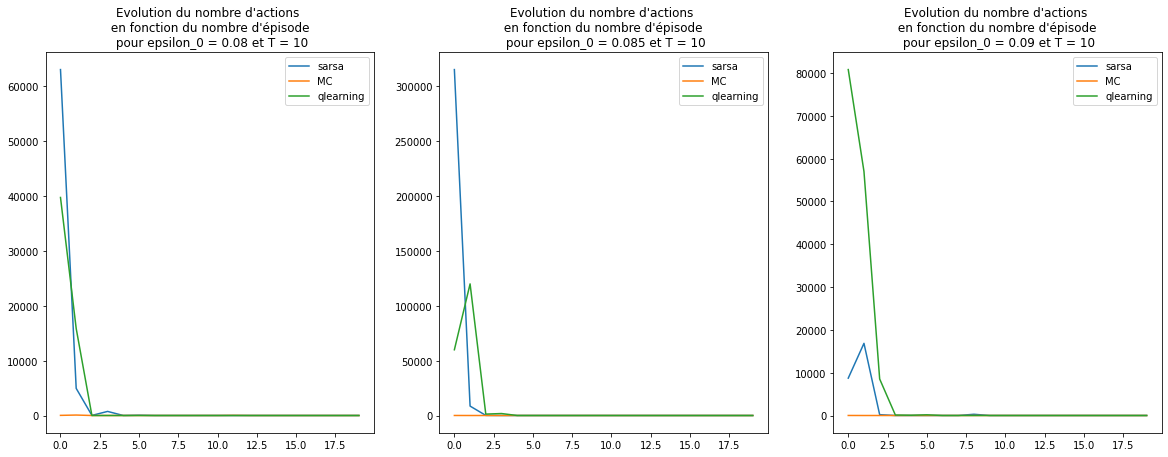

In [ ]:
epsilon_0 = [0.08, 0.085, 0.09]
fig, axes = plt.subplots(1,3)
for i in [0,1,2]:
    fig = plt.subplot(1,3,i+1)
    fig = plt.plot(sarsa_results[0][i], label='sarsa')
    fig = plt.plot(monte_carlo_results[0][i], label='MC')
    fig = plt.plot(q_learning_results[0][i], label='qlearning')
    fig = plt.legend()
    fig = plt.title('Evolution du nombre d\'actions \n en fonction du nombre d\'épisode \n pour epsilon_0 = {} et T = 10'.format(epsilon_0[i]))
fig = plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig = plt.show()

On peut aussi faire varier $T$ : 

In [ ]:
gamma = 0.9
alpha = 0.1
nb_episodes = 10

monte_carlo_results = [[],[]]
sarsa_results = [[],[]]
q_learning_results = [[],[]]
for T in [5, 10, 15]:
    epsilon_0 = 0.08
    _, nba_by_episodes, r_by_episodes = monte_carlo_m(env, gamma, nb_episodes, epsilon_0, T)
    monte_carlo_results[0].append(nba_by_episodes)
    monte_carlo_results[1].append(r_by_episodes)

    _, nba_by_episodes, r_by_episodes = sarsa_m(env, gamma, alpha, nb_episodes, epsilon_0, T)
    sarsa_results[0].append(nba_by_episodes)
    sarsa_results[1].append(r_by_episodes)

    _, nba_by_episodes, r_by_episodes = q_learning_m(env, gamma, alpha, nb_episodes, epsilon_0, T)
    q_learning_results[0].append(nba_by_episodes)
    q_learning_results[1].append(r_by_episodes)

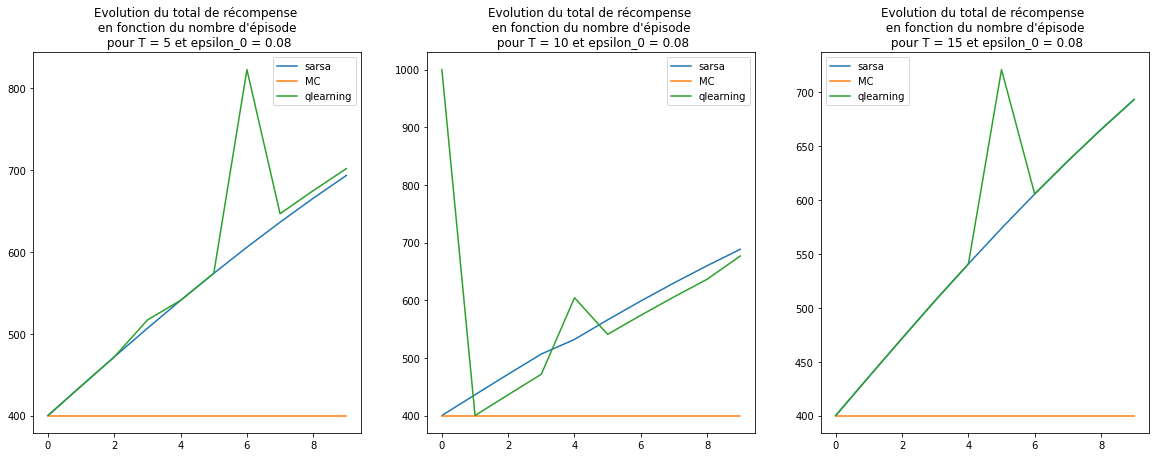

In [ ]:
T = [5, 10, 15]
fig, axes = plt.subplots(1,3)
for i in [0,1,2]:
    fig = plt.subplot(1,3,i+1)
    fig = plt.plot(sarsa_results[1][i], label='sarsa')
    fig = plt.plot(monte_carlo_results[1][i], label='MC')
    fig = plt.plot(q_learning_results[1][i], label='qlearning')
    fig = plt.legend()
    fig = plt.title('Evolution du total de récompense \n en fonction du nombre d\'épisode \n pour T = {} et epsilon_0 = 0.08'.format(T[i]))
fig = plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig = plt.show()

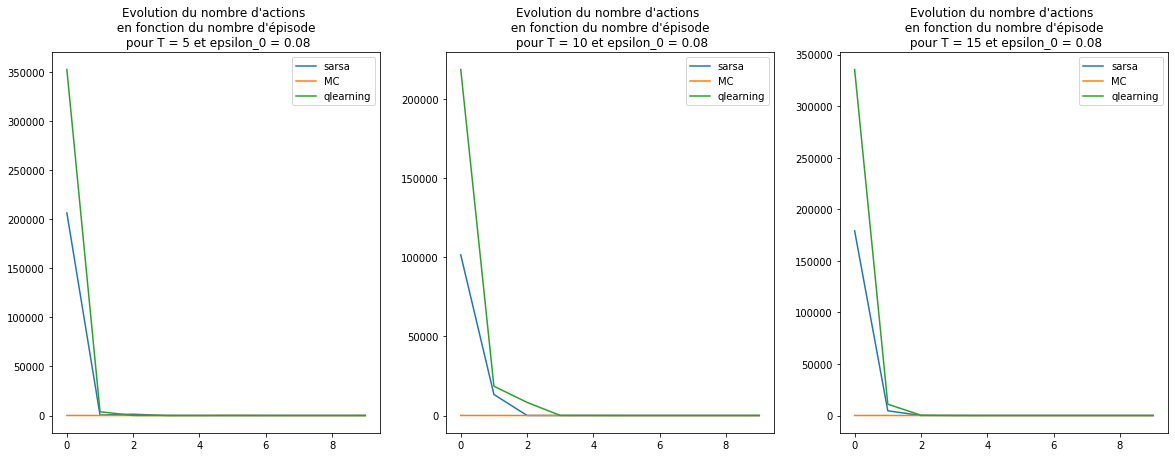

In [ ]:
T = [5, 10, 15]
fig, axes = plt.subplots(1,3)
for i in [0,1,2]:
    fig = plt.subplot(1,3,i+1)
    fig = plt.plot(sarsa_results[0][i], label='sarsa')
    fig = plt.plot(monte_carlo_results[0][i], label='MC')
    fig = plt.plot(q_learning_results[0][i], label='qlearning')
    fig = plt.legend()
    fig = plt.title('Evolution du nombre d\'actions \n en fonction du nombre d\'épisode \n pour T = {} et epsilon_0 = 0.08'.format(T[i]))
fig = plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig = plt.show()